In [1]:
import gc
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from langchain_community.vectorstores import Neo4jVector
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_neo4j import Neo4jGraph
from sentence_transformers import CrossEncoder

In [2]:
plt.style.use("default")
sns.set_palette("husl")

In [3]:
def clear_gpu_memory(verbose=True):
    """Comprehensive GPU memory clearing function"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()

        if verbose:
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            free = (
                torch.cuda.get_device_properties(0).total_memory
                - torch.cuda.memory_reserved()
            ) / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            print(
                f"GPU Memory - Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB | Free: {free:.2f} GB | Total: {total:.2f} GB"
            )
            return {
                "allocated": allocated,
                "reserved": reserved,
                "free": free,
                "total": total,
            }
    else:
        print("CUDA not available")
        return None

In [4]:
def get_gpu_memory_info():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        free = total - reserved
        return {
            "allocated": allocated,
            "reserved": reserved,
            "free": free,
            "total": total,
            "utilization": (reserved / total) * 100,
        }
    return None


def monitor_gpu_memory(step_name: str):
    """Monitor and log GPU memory at each step"""
    memory_info = get_gpu_memory_info()
    if memory_info:
        print(
            f"[{step_name}] GPU Utilization: {memory_info['utilization']:.1f}% | "
            f"Reserved: {memory_info['reserved']:.2f}/{memory_info['total']:.2f} GB"
        )

In [5]:
# Clear GPU memory before starting
print("Initial GPU state:")
clear_gpu_memory()

# Load embeddings model with optimizations for GTX 1650
embeddings_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-base-en-v1.5",
    model_kwargs={
        "device": "cuda",
        "trust_remote_code": True,
    },
    encode_kwargs={
        "normalize_embeddings": True,  # Better similarity scores
        "batch_size": 16,  # Conservative batch size for GTX 1650
    },
)

print("Embeddings model initialized successfully")
monitor_gpu_memory("After Embeddings Load")

Initial GPU state:
GPU Memory - Allocated: 0.00 GB | Reserved: 0.00 GB | Free: 4.29 GB | Total: 4.29 GB
Embeddings model initialized successfully
[After Embeddings Load] GPU Utilization: 11.5% | Reserved: 0.49/4.29 GB


In [6]:
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "yourpassword"

# Initialize the Neo4jGraph object with the connection parameters
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
)

print("Connected to Neo4j successfully")
print("Graph schema:")
print(graph.schema)

Connected to Neo4j successfully
Graph schema:
Node properties:
Chunk {embedding: LIST, subchapter_number: INTEGER, chapter_number: INTEGER, content: STRING, tags: LIST}
Chapter {number: INTEGER, title: STRING, id: STRING}
Concept {normalized_name: STRING, name: STRING}
Relationship properties:

The relationships:
(:Chunk)-[:RELATES_TO]->(:Concept)
(:Chapter)-[:CONTAINS]->(:Chunk)
(:Concept)-[:CO_OCCURS_WITH]->(:Concept)


In [7]:
def create_chunk_embeddings():
    """Create vector embeddings for all chunk nodes in the graph"""
    chunk_vector_store = Neo4jVector.from_existing_graph(
        embedding=embeddings_model,
        url=NEO4J_URI,
        username=NEO4J_USERNAME,
        password=NEO4J_PASSWORD,
        index_name="chunkEmbeddings",
        node_label="Chunk",
        text_node_properties=["content"],
        embedding_node_property="embedding",
        search_type="hybrid",
    )

    print("Vector embeddings created for chunk nodes")
    return chunk_vector_store


chunk_vector_store = create_chunk_embeddings()
monitor_gpu_memory("After Vector Store Creation")

Vector embeddings created for chunk nodes
[After Vector Store Creation] GPU Utilization: 11.5% | Reserved: 0.49/4.29 GB


In [8]:
# Search parameters
query = "What about climate shocks and inflation?"
k_retrieve = 30  # Number of documents to retrieve
k_rerank = 12  # Number of documents to rerank (optimized for GTX 1650)
k_display = 10  # Number of final results to display

print(f"Starting search with query: '{query}'")
print(
    f"Retrieving {k_retrieve} documents, reranking top {k_rerank}, displaying top {k_display}"
)

# Retrieve documents using embeddings model
simResults = chunk_vector_store.similarity_search_with_relevance_scores(
    query, k=k_retrieve, score_threshold=0.75
)

print(f"Retrieved {len(simResults)} documents above threshold")
monitor_gpu_memory("After Similarity Search")

Starting search with query: 'What about climate shocks and inflation?'
Retrieving 30 documents, reranking top 12, displaying top 10


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['content'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedd

Retrieved 30 documents above threshold
[After Similarity Search] GPU Utilization: 11.5% | Reserved: 0.49/4.29 GB


In [9]:
# CRITICAL: Free embeddings model to make room for reranker on GTX 1650
print("Freeing embeddings model to load reranker...")

# Delete embeddings model and clear cache
del embeddings_model
clear_gpu_memory()
monitor_gpu_memory("After Embeddings Cleanup")

# Now load reranker with optimized settings for GTX 1650
print("Loading reranker model...")
reranker = CrossEncoder(
    "BAAI/bge-reranker-base",
    device="cuda",
    max_length=512,  # Limit sequence length to save memory
)

print("BGE Reranker loaded successfully")
monitor_gpu_memory("After Reranker Load")

Freeing embeddings model to load reranker...
GPU Memory - Allocated: 0.45 GB | Reserved: 0.49 GB | Free: 3.80 GB | Total: 4.29 GB
[After Embeddings Cleanup] GPU Utilization: 11.5% | Reserved: 0.49/4.29 GB
Loading reranker model...
BGE Reranker loaded successfully
[After Reranker Load] GPU Utilization: 38.2% | Reserved: 1.64/4.29 GB


In [10]:
# %%
def batch_rerank(
    reranker, pairs: List[Tuple[str, str]], batch_size: int = 4
) -> List[float]:
    """
    Rerank pairs in batches optimized for GTX 1650

    Args:
        reranker: CrossEncoder model
        pairs: List of (query, document) pairs
        batch_size: Size of each batch (small for GTX 1650)

    Returns:
        List of reranker scores
    """
    all_scores = []
    total_batches = (len(pairs) + batch_size - 1) // batch_size

    print(f"Processing {len(pairs)} pairs in {total_batches} batches of {batch_size}")

    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i : i + batch_size]
        batch_num = i // batch_size + 1

        print(f"Processing batch {batch_num}/{total_batches}...")

        batch_scores = reranker.predict(batch_pairs)
        all_scores.extend(
            batch_scores.tolist() if hasattr(batch_scores, "tolist") else batch_scores
        )

        # Clear cache after each batch for memory efficiency
        torch.cuda.empty_cache()

        # Monitor memory every few batches
        if batch_num % 3 == 0 or batch_num == total_batches:
            monitor_gpu_memory(f"Batch {batch_num}/{total_batches}")

    return all_scores


def compare_rankings(
    original_results: List[Tuple],
    reranked_results: List[Tuple],
    query: str,
    top_k: int = 10,
) -> Dict[str, Any]:
    """
    Compare original similarity search results with reranked results

    Args:
        original_results: List of (document, similarity_score) tuples
        reranked_results: List of (document, reranker_score) tuples
        query: The search query
        top_k: Number of top results to compare

    Returns:
        Dictionary containing comparison metrics and visualizations
    """
    # Limit to top_k results for comparison
    orig_top = original_results[:top_k]
    rerank_top = reranked_results[:top_k]

    # Create comparison dataframe
    comparison_data = []

    # Create mapping of document content to original rank and score
    orig_doc_to_info = {
        doc.page_content: {"rank": i + 1, "score": sim_score}
        for i, (doc, sim_score) in enumerate(original_results)
    }

    for new_rank, (doc, rerank_score) in enumerate(rerank_top, 1):
        orig_info = orig_doc_to_info.get(
            doc.page_content, {"rank": "Not in results", "score": None}
        )
        orig_rank = orig_info["rank"]
        orig_score = orig_info["score"]

        rank_change = None
        if isinstance(orig_rank, int):
            rank_change = orig_rank - new_rank

        comparison_data.append(
            {
                "content_preview": doc.page_content[:100] + "...",
                "original_rank": orig_rank,
                "reranked_rank": new_rank,
                "rank_change": rank_change,
                "similarity_score": orig_score,
                "reranker_score": rerank_score,
                "metadata": str(doc.metadata),
                "doc_id": doc.metadata.get("id", f"doc_{new_rank}"),
            }
        )

    df = pd.DataFrame(comparison_data)

    # Print detailed comparison table
    print("=" * 140)
    print(f"RANKING COMPARISON FOR QUERY: '{query}'")
    print("=" * 140)
    print(
        f"{'New':>4} | {'Orig':>6} | {'Change':>8} | {'Sim Score':>10} | {'Rerank Score':>12} | {'Improvement':>12} | Content Preview"
    )
    print("-" * 140)

    for _, row in df.iterrows():
        change_str = "NEW" if row["rank_change"] is None else f"{row['rank_change']:+d}"
        improvement = ""
        if row["rank_change"] is not None and row["rank_change"] != 0:
            improvement = "↑ BETTER" if row["rank_change"] > 0 else "↓ WORSE"

        sim_score_str = (
            f"{row['similarity_score']:.4f}" if row["similarity_score"] else "N/A"
        )

        print(
            f"{row['reranked_rank']:>4} | {row['original_rank']:>6} | {change_str:>8} | {sim_score_str:>10} | "
            f"{row['reranker_score']:>12.4f} | {improvement:>12} | {row['content_preview']}"
        )

    # Calculate detailed metrics
    numeric_changes = [change for change in df["rank_change"] if change is not None]
    improvements = [change for change in numeric_changes if change > 0]
    declines = [change for change in numeric_changes if change < 0]

    metrics = {
        "total_documents": len(df),
        "documents_with_rank_changes": len([c for c in numeric_changes if c != 0]),
        "improvements": len(improvements),
        "declines": len(declines),
        "no_change": len([c for c in numeric_changes if c == 0]),
        "avg_rank_change": sum(numeric_changes) / len(numeric_changes)
        if numeric_changes
        else 0,
        "max_improvement": max(improvements) if improvements else 0,
        "max_decline": min(declines) if declines else 0,
        "avg_similarity_score": df["similarity_score"].mean(),
        "avg_reranker_score": df["reranker_score"].mean(),
        "score_correlation": df[["similarity_score", "reranker_score"]]
        .corr()
        .iloc[0, 1]
        if len(df) > 1
        else None,
        "comparison_df": df,
    }

    # Print comprehensive metrics
    print("\n" + "=" * 80)
    print("DETAILED COMPARISON METRICS:")
    print("=" * 80)
    print(f"Total documents compared: {metrics['total_documents']}")
    print(f"Documents with rank changes: {metrics['documents_with_rank_changes']}")
    print(f"  • Improved ranking: {metrics['improvements']}")
    print(f"  • Declined ranking: {metrics['declines']}")
    print(f"  • No change: {metrics['no_change']}")
    print(f"Average rank change: {metrics['avg_rank_change']:.2f}")
    print(f"Best improvement: +{metrics['max_improvement']} positions")
    print(f"Worst decline: {metrics['max_decline']} positions")
    print(f"Average similarity score: {metrics['avg_similarity_score']:.4f}")
    print(f"Average reranker score: {metrics['avg_reranker_score']:.4f}")
    if metrics["score_correlation"]:
        print(f"Score correlation: {metrics['score_correlation']:.4f}")

    return metrics


def plot_ranking_comparison(
    comparison_df: pd.DataFrame, query: str, save_path: str = None
):
    """
    Create comprehensive visualizations of ranking changes
    """
    # Filter out non-numeric rank changes for plotting
    numeric_df = comparison_df[comparison_df["rank_change"].notna()].copy()

    if len(numeric_df) == 0:
        print("No numeric rank changes to visualize")
        return

    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(
        f'Ranking Analysis for Query: "{query[:50]}..."', fontsize=14, fontweight="bold"
    )

    # Plot 1: Rank position changes
    colors = [
        "green" if x > 0 else "red" if x < 0 else "gray"
        for x in numeric_df["rank_change"]
    ]
    ax1.scatter(
        numeric_df["original_rank"],
        numeric_df["reranked_rank"],
        c=colors,
        alpha=0.7,
        s=60,
        edgecolors="black",
        linewidths=0.5,
    )

    # Add diagonal line for no change
    max_rank = max(numeric_df["original_rank"].max(), numeric_df["reranked_rank"].max())
    ax1.plot(
        [1, max_rank], [1, max_rank], "k--", alpha=0.5, linewidth=2, label="No change"
    )

    ax1.set_xlabel("Original Rank")
    ax1.set_ylabel("Reranked Position")
    ax1.set_title("Position Changes (Green=Improved, Red=Declined)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add annotations for major changes
    for _, row in numeric_df.iterrows():
        if abs(row["rank_change"]) >= 3:  # Annotate significant changes
            ax1.annotate(
                f"{row['rank_change']:+d}",
                (row["original_rank"], row["reranked_rank"]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=8,
            )

    # Plot 2: Score correlation
    ax2.scatter(
        numeric_df["similarity_score"],
        numeric_df["reranker_score"],
        alpha=0.7,
        s=60,
        edgecolors="black",
        linewidths=0.5,
    )
    ax2.set_xlabel("Similarity Score")
    ax2.set_ylabel("Reranker Score")
    ax2.set_title("Score Correlation")
    ax2.grid(True, alpha=0.3)

    # Add correlation coefficient
    corr = numeric_df["similarity_score"].corr(numeric_df["reranker_score"])
    ax2.text(
        0.05,
        0.95,
        f"Correlation: {corr:.3f}",
        transform=ax2.transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    # Plot 3: Rank change distribution
    rank_changes = numeric_df["rank_change"].values
    ax3.hist(
        rank_changes, bins=min(15, len(set(rank_changes))), alpha=0.7, edgecolor="black"
    )
    ax3.axvline(0, color="red", linestyle="--", alpha=0.7, label="No change")
    ax3.set_xlabel("Rank Change (+ = Improved)")
    ax3.set_ylabel("Count")
    ax3.set_title("Distribution of Rank Changes")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Score comparison by rank change direction
    improvements = numeric_df[numeric_df["rank_change"] > 0]
    declines = numeric_df[numeric_df["rank_change"] < 0]
    no_change = numeric_df[numeric_df["rank_change"] == 0]

    categories = []
    sim_scores = []
    rerank_scores = []

    if len(improvements) > 0:
        categories.extend(["Improved"] * len(improvements))
        sim_scores.extend(improvements["similarity_score"])
        rerank_scores.extend(improvements["reranker_score"])

    if len(declines) > 0:
        categories.extend(["Declined"] * len(declines))
        sim_scores.extend(declines["similarity_score"])
        rerank_scores.extend(declines["reranker_score"])

    if len(no_change) > 0:
        categories.extend(["No Change"] * len(no_change))
        sim_scores.extend(no_change["similarity_score"])
        rerank_scores.extend(no_change["reranker_score"])

    if categories:
        score_comparison_df = pd.DataFrame(
            {
                "Category": categories,
                "Similarity": sim_scores,
                "Reranker": rerank_scores,
            }
        )

        x_pos = range(len(set(categories)))
        width = 0.35

        for i, cat in enumerate(set(categories)):
            cat_data = score_comparison_df[score_comparison_df["Category"] == cat]
            ax4.bar(
                [i - width / 2],
                [cat_data["Similarity"].mean()],
                width,
                label="Similarity" if i == 0 else "",
                alpha=0.7,
            )
            ax4.bar(
                [i + width / 2],
                [cat_data["Reranker"].mean()],
                width,
                label="Reranker" if i == 0 else "",
                alpha=0.7,
            )

        ax4.set_xlabel("Rank Change Category")
        ax4.set_ylabel("Average Score")
        ax4.set_title("Average Scores by Rank Change")
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(set(categories))
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Visualization saved to: {save_path}")

    plt.show()

In [11]:
# %%
# Optimize reranking by only reranking top results
top_sim_results = simResults[:k_rerank]

# Create pairs for reranking
pairs = [(query, doc.page_content) for doc, _ in top_sim_results]

print(f"Reranking top {len(pairs)} document pairs...")

# Use optimized batch reranking for GTX 1650
scores = batch_rerank(reranker, pairs, batch_size=4)

print("Reranking completed successfully!")
monitor_gpu_memory("After Reranking Complete")

# Attach reranker scores back
reranked = sorted(
    zip([doc for doc, _ in top_sim_results], scores), key=lambda x: x[1], reverse=True
)

Reranking top 12 document pairs...
Processing 12 pairs in 3 batches of 4
Processing batch 1/3...
Processing batch 2/3...
Processing batch 3/3...
[Batch 3/3] GPU Utilization: 38.2% | Reserved: 1.64/4.29 GB
Reranking completed successfully!
[After Reranking Complete] GPU Utilization: 38.2% | Reserved: 1.64/4.29 GB


In [12]:
# %%
# Compare original vs reranked results with comprehensive analysis
comparison_metrics = compare_rankings(
    original_results=simResults, reranked_results=reranked, query=query, top_k=k_display
)

RANKING COMPARISON FOR QUERY: 'What about climate shocks and inflation?'
 New |   Orig |   Change |  Sim Score | Rerank Score |  Improvement | Content Preview
--------------------------------------------------------------------------------------------------------------------------------------------
   1 |      5 |       +4 |     0.9732 |       0.0521 |     ↑ BETTER | 
content: Chapter 1 Summary:
The global economy exhibited steady yet uneven growth across regions in...
   2 |      9 |       +7 |     0.9360 |       0.0521 |     ↑ BETTER | 
content: Chapter 1 Summary:
The global economy exhibited steady yet uneven growth across regions in...
   3 |     10 |       +7 |     0.9360 |       0.0521 |     ↑ BETTER | 
content: Chapter 1 Summary:
The global economy exhibited steady yet uneven growth across regions in...
   4 |     11 |       +7 |     0.9360 |       0.0521 |     ↑ BETTER | 
content: Chapter 1 Summary:
The global economy exhibited steady yet uneven growth across regions in...
   5

Visualization saved to: ranking_comparison_What_about_climate_s.png


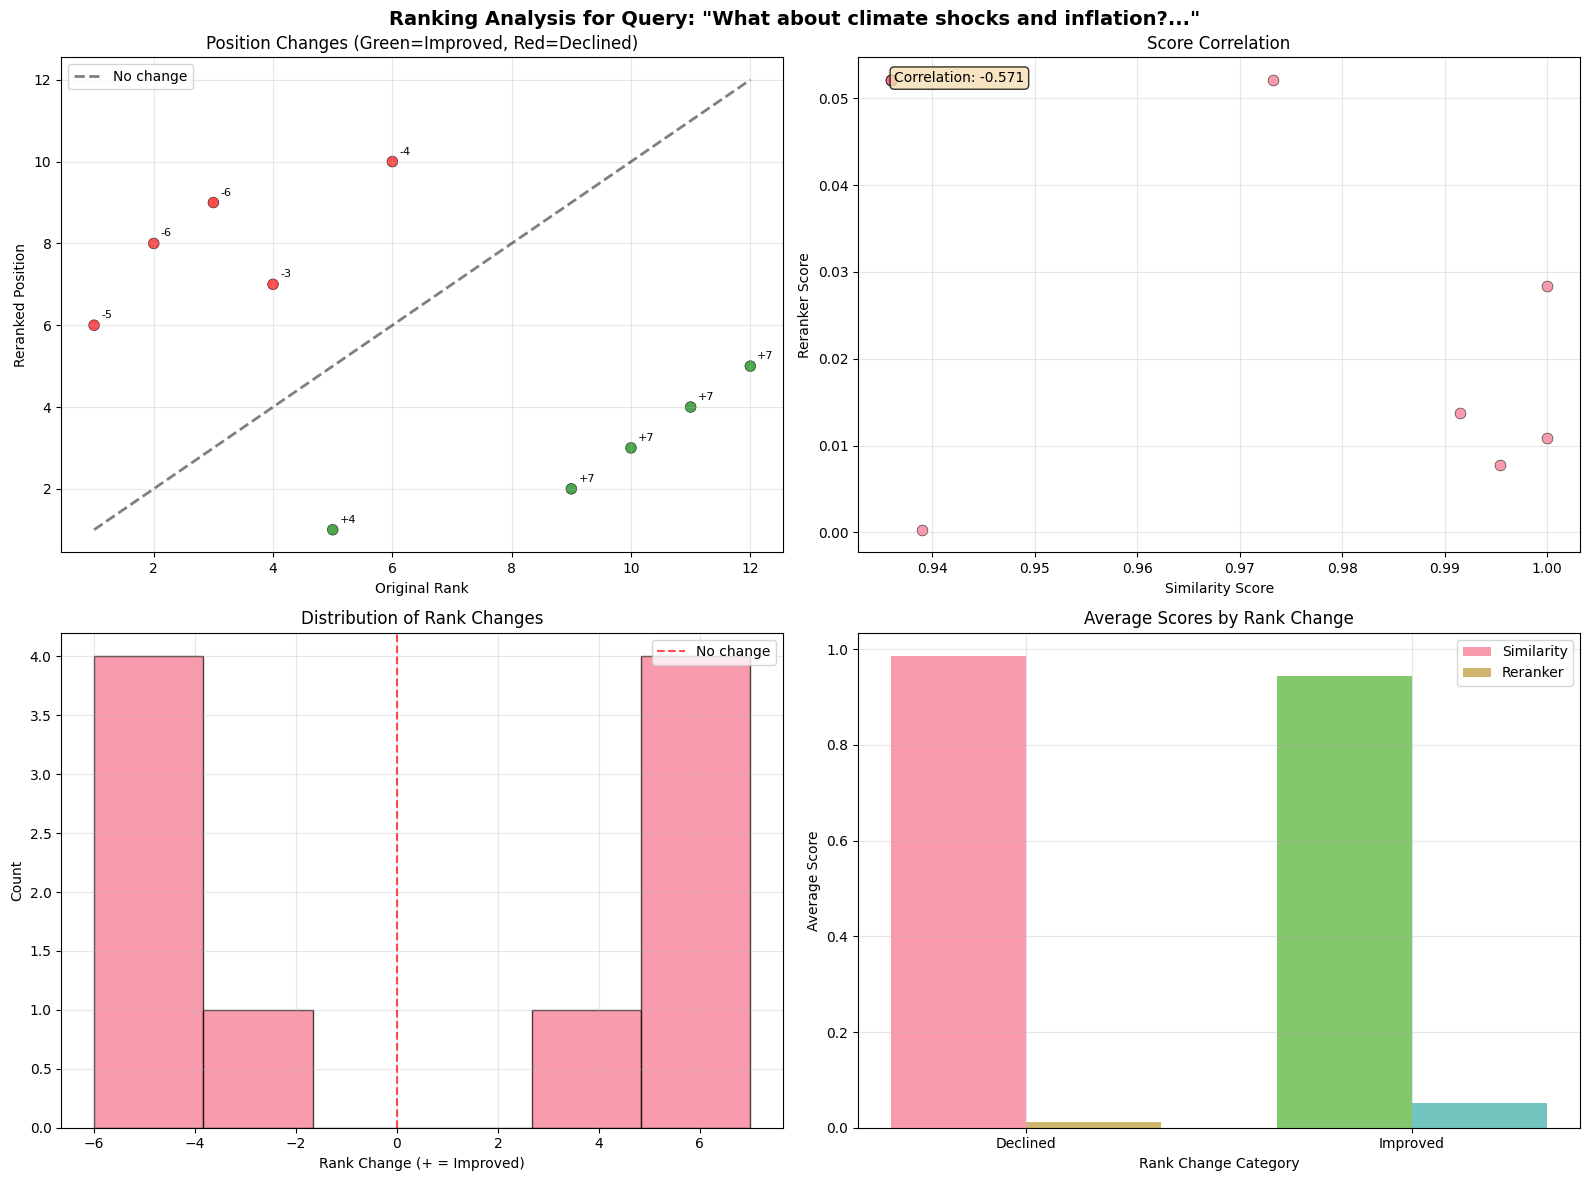

In [13]:
# %%
# Create visualization of the comparison
plot_ranking_comparison(
    comparison_metrics["comparison_df"],
    query=query,
    save_path=f"ranking_comparison_{query[:20].replace(' ', '_')}.png",
)

In [14]:
# %%
# Display top reranked results with enhanced formatting
print("\n" + "=" * 120)
print("🏆 TOP RERANKED RESULTS:")
print("=" * 120)

for i, (doc, score) in enumerate(reranked[:k_display], start=1):
    # Find original rank for comparison
    orig_rank = "Not found"
    for j, (orig_doc, _) in enumerate(simResults, 1):
        if orig_doc.page_content == doc.page_content:
            orig_rank = j
            break

    rank_change_indicator = ""
    if isinstance(orig_rank, int):
        change = orig_rank - i
        if change > 0:
            rank_change_indicator = f" (↑+{change} from #{orig_rank})"
        elif change < 0:
            rank_change_indicator = f" (↓{change} from #{orig_rank})"
        else:
            rank_change_indicator = f" (same as #{orig_rank})"

    print("=" * 100)
    print(f"🥇 Rank {i}{rank_change_indicator}")
    print(f"📊 Reranker Score: {score:.4f}")
    print(f"📋 Metadata: {doc.metadata}")
    print(f"📄 Content Preview:")
    print(doc.page_content[:500] + ("..." if len(doc.page_content) > 500 else ""))


🏆 TOP RERANKED RESULTS:
🥇 Rank 1 (↑+4 from #5)
📊 Reranker Score: 0.0521
📋 Metadata: {'tags': ['Global_Economic_Conditions', 'Macroeconomic_Trends', 'Growth_and_Inflation'], 'subchapter_number': 2, 'chapter_number': 1}
📄 Content Preview:

content: Chapter 1 Summary:
The global economy exhibited steady yet uneven growth across regions in 2024. The slowdown in global manufacturing, especially in Europe and parts of Asia, was due to supply chain disruptions and weak external demand. In contrast, the services sector performed better, supporting growth in many economies. Inflationary pressures eased in most economies, but services inflation remained persistent. Commodity prices stabilized, but the risk of synchronised price increases...
🥇 Rank 2 (↑+7 from #9)
📊 Reranker Score: 0.0521
📋 Metadata: {'tags': ['Global_Economic_Growth', 'Inflation_Rates', 'Trade_Policy_Uncertainty'], 'subchapter_number': 3, 'chapter_number': 1}
📄 Content Preview:

content: Chapter 1 Summary:
The global economy ex

In [15]:
# %%
# Optional: Clean up reranker model if needed for other tasks
def cleanup_reranker():
    """Clean up reranker model and free GPU memory"""
    global reranker

    print("Cleaning up reranker model...")

    if "reranker" in globals():
        del reranker

    final_memory = clear_gpu_memory()
    print("Reranker model cleaned up successfully!")
    return final_memory


# Monitor final GPU state
print("\n" + "=" * 80)
print("🎯 PROCESSING COMPLETED SUCCESSFULLY!")
print("=" * 80)
monitor_gpu_memory("Final State")

# Uncomment the next line if you want to free GPU memory after processing
# cleanup_reranker()


🎯 PROCESSING COMPLETED SUCCESSFULLY!
[Final State] GPU Utilization: 38.2% | Reserved: 1.64/4.29 GB
